In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from src.dataset import ProteinDataset
from src.utils import train_model, test_model
import torch
from src.model import ChemicalShiftsPredictor, ChemicalShiftsPredictorAttention
from src.utils import packed_padded_collate

from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import h5py

/tmp/ipykernel_1167/1785675692.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load and prepare data
csv_file = 'data/strict.csv'
prott5_file = 'data/embeddings/unfiltered_all_prott5.h5'
prott5_res_file = 'data/embeddings/unfiltered_all_prott5_res.h5'
prostt5_file = 'data/embeddings/prostt5.h5'
esm_file = 'data/embeddings/unfiltered_all_esm2_3b.h5'
esm_res_file = 'data/embeddings/unfiltered_all_esm2_3b_res.h5'
chemical_shifts_df = pd.read_csv(csv_file)
#chemical_shifts_df.describe()

In [3]:
test_ids = []
with open("pdb_matched/final_test_ids.txt", "r") as f:
    for line in f:
        test_ids.append(line.strip())

In [4]:
chemical_shifts_df = chemical_shifts_df[~chemical_shifts_df['ID'].isin(test_ids)]

In [5]:
chemical_shifts_df.dropna(inplace=True, subset=["N"])

In [6]:
# split dataset into train and test, based on unique protein IDs
ids = chemical_shifts_df['ID'].unique()
train_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=42)
train_df = chemical_shifts_df[chemical_shifts_df['ID'].isin(train_ids)]
val_df = chemical_shifts_df[chemical_shifts_df['ID'].isin(test_ids)]

In [7]:
prostt5_embs = h5py.File(prostt5_file, "r")
prott5_embs = h5py.File(prott5_file, "r")

In [8]:
# get prosst5 embeddings for train and test
train_X = []
for row in tqdm(train_df.itertuples(), total=len(train_df)):
    protein_id = row.ID
    amino_acid_index = row.seq_index - 1  # Adjust for zero-based indexing
    amino_acid_prostt5_emb = prostt5_embs[protein_id][amino_acid_index]
    
    prot_emb = prott5_embs[protein_id]
    
    train_X.append(np.concatenate([amino_acid_prostt5_emb.flatten()], axis=0))

  0%|          | 0/144973 [00:00<?, ?it/s]

In [9]:
val_X = []
for row in tqdm(val_df.itertuples(), total=len(val_df)):
    protein_id = row.ID
    amino_acid_index = row.seq_index - 1  # Adjust for zero-based indexing
    amino_acid_prostt5_emb = prostt5_embs[protein_id][amino_acid_index]
    
    prot_emb = prott5_embs[protein_id]
    
    val_X.append(np.concatenate([amino_acid_prostt5_emb.flatten()], axis=0))


  0%|          | 0/35552 [00:00<?, ?it/s]

In [10]:
train_y = list(train_df['N'].values)
val_y = list(val_df['N'].values)

In [11]:
len(train_y)

144973

In [43]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(train_X, train_y)
#change feature numeration from 0 to 1
val_data = train_data.set_feature_names(list(range(1, 1025)))

val_data = Pool(val_X, val_y)
#change feature numeration from 0 to 1
val_data = val_data.set_feature_names(list(range(1, 1025)))

In [46]:
model = CatBoostRegressor(iterations=100, loss_function='RMSEWithUncertainty', posterior_sampling=True)
#model = CatBoostRegressor(iterations=100, task_type="CPU")
model.fit(train_data , eval_set=val_data, verbose=True)

0:	learn: 3.0847239	test: 3.0759453	best: 3.0759453 (0)	total: 384ms	remaining: 38s
1:	learn: 3.0749458	test: 3.0659519	best: 3.0659519 (1)	total: 593ms	remaining: 29s
2:	learn: 3.0648967	test: 3.0559116	best: 3.0559116 (2)	total: 818ms	remaining: 26.4s
3:	learn: 3.0563293	test: 3.0471409	best: 3.0471409 (3)	total: 1.03s	remaining: 24.7s
4:	learn: 3.0482565	test: 3.0390410	best: 3.0390410 (4)	total: 1.23s	remaining: 23.3s
5:	learn: 3.0399502	test: 3.0307382	best: 3.0307382 (5)	total: 1.43s	remaining: 22.4s
6:	learn: 3.0326375	test: 3.0234300	best: 3.0234300 (6)	total: 1.7s	remaining: 22.6s
7:	learn: 3.0256969	test: 3.0164259	best: 3.0164259 (7)	total: 1.96s	remaining: 22.6s
8:	learn: 3.0186123	test: 3.0092939	best: 3.0092939 (8)	total: 2.18s	remaining: 22s
9:	learn: 3.0130024	test: 3.0036218	best: 3.0036218 (9)	total: 2.38s	remaining: 21.4s
10:	learn: 3.0072971	test: 2.9978614	best: 2.9978614 (10)	total: 2.57s	remaining: 20.8s
11:	learn: 3.0017787	test: 2.9923000	best: 2.9923000 (11)	t

In [47]:
model.save_model("models/n_catboost_uncertainty.cbm")

In [24]:
# load catboost model
model = CatBoostRegressor()
model.load_model("models/n_catboost_uncertainty.cbm")

In [19]:
test_ids = []
with open("pdb_matched/final_test_ids.txt", "r") as f:
    for line in f:
        test_ids.append(line.strip())

In [20]:
chemical_shifts_df = pd.read_csv(csv_file)
# take test ids
chemical_shifts_df = chemical_shifts_df[chemical_shifts_df['ID'].isin(test_ids)]

#test on them
test_X = []
for row in tqdm(chemical_shifts_df.itertuples(), total=len(chemical_shifts_df)):
    protein_id = row.ID
    amino_acid_index = row.seq_index - 1  # Adjust for zero-based indexing
    amino_acid_prostt5_emb = prostt5_embs[protein_id][amino_acid_index]
    
    prot_emb = prott5_embs[protein_id]
    
    test_X.append(np.concatenate([amino_acid_prostt5_emb.flatten(), np.array(prot_emb).flatten()], axis=0))

test_y = list(chemical_shifts_df['H'].values)

preds = model.predict(test_X)

  0%|          | 0/12892 [00:00<?, ?it/s]

In [21]:
# select N_our, H_our, ID, entryID, seq_index, seq and save to csv
df = pd.DataFrame({'H_cat': preds, 'ID': chemical_shifts_df['ID'], 'entryID': chemical_shifts_df['entryID'], 'seq_index': chemical_shifts_df['seq_index'], 'seq': chemical_shifts_df['seq']})
df.to_csv("test_n_catboost_prostt5.csv", index=False)

In [53]:
preds = model.virtual_ensembles_predict(val_data, prediction_type='TotalUncertainty', 
                                                virtual_ensembles_count=20)

In [55]:
mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
model_uncertainty = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = preds[:,2] # average estimated data uncertainty

In [57]:
# ration of knowledge uncertainty to data uncertainty
sum(model_uncertainty) / (sum(data_uncertainty) + sum(model_uncertainty))

0.0009340730662466402

/tmp/ipykernel_1167/1062732999.py:4: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=model_uncertainty, y=np.array(val_y) - mean_preds, cmap="Blues", shade=True, shade_lowest=False);
/tmp/ipykernel_1167/1062732999.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=model_uncertainty, y=np.array(val_y) - mean_preds, cmap="Blues", shade=True, shade_lowest=False);


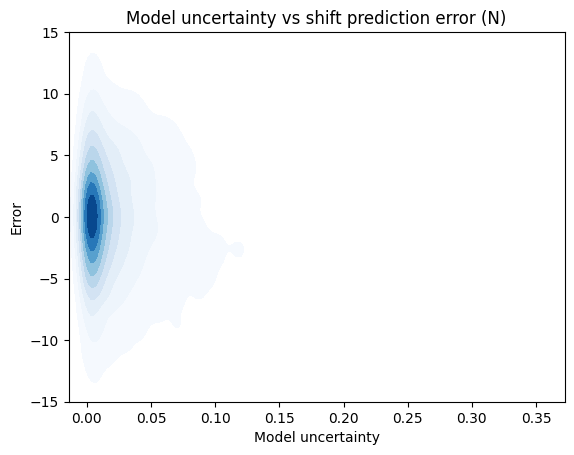

In [80]:
# plot model uncertainty vs squared error
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(x=model_uncertainty, y=np.array(val_y) - mean_preds, cmap="Blues", shade=True, shade_lowest=False);
plt.title("Model uncertainty vs shift prediction error (N)");
plt.xlabel("Model uncertainty");
plt.ylabel("Error");
# limit y from -15 to 15
plt.ylim(-15, 15);

/tmp/ipykernel_1167/2219157415.py:7: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data_uncertainty, y=np.array(val_y) - mean_preds, cmap="Blues", shade=True, shade_lowest=False);
/tmp/ipykernel_1167/2219157415.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data_uncertainty, y=np.array(val_y) - mean_preds, cmap="Blues", shade=True, shade_lowest=False);


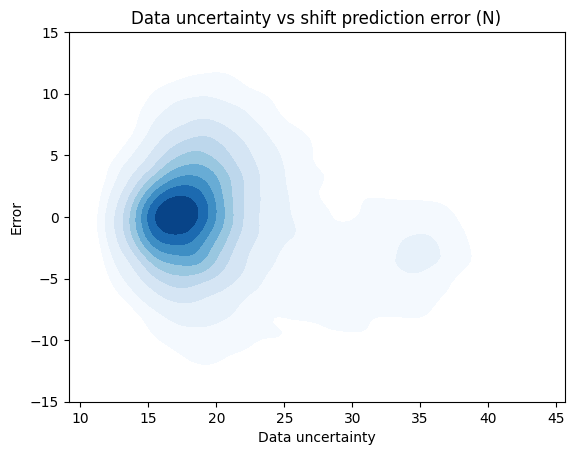

In [72]:
# plot data uncertainty vs squared error
#plt.scatter(data_uncertainty, np.array(val_y) - mean_preds);


#plot density plot of data uncertainty vs squared error
import seaborn as sns
sns.kdeplot(x=data_uncertainty, y=np.array(val_y) - mean_preds, cmap="Blues", shade=True, shade_lowest=False);
plt.title("Data uncertainty vs shift prediction error (N)");
plt.xlabel("Data uncertainty");
plt.ylabel("Error");
plt.ylim(-15, 15);

In [74]:
val_df['zscores']

1463      12.4005
1464      14.0397
1465      12.0803
1466      10.6632
1467      10.7870
           ...   
216838    15.0991
216839    13.5895
216840    12.3478
216841     8.9248
216842        NaN
Name: zscores, Length: 35552, dtype: float64

/tmp/ipykernel_1167/1992982398.py:2: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=model_uncertainty, y=val_df['zscores'], cmap="Blues", shade=True, shade_lowest=False);
/tmp/ipykernel_1167/1992982398.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=model_uncertainty, y=val_df['zscores'], cmap="Blues", shade=True, shade_lowest=False);


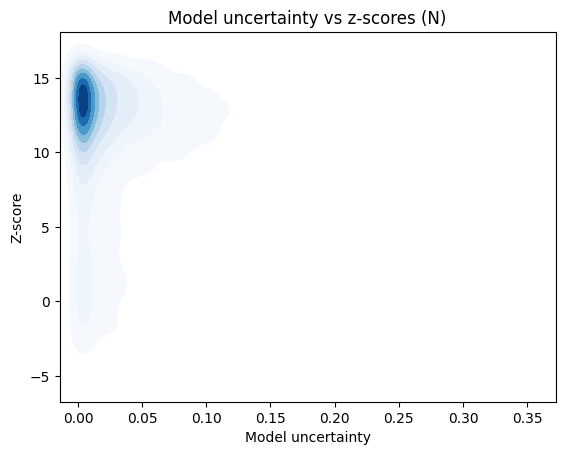

In [75]:
# plot model uncertainty vs z-scores
sns.kdeplot(x=model_uncertainty, y=val_df['zscores'], cmap="Blues", shade=True, shade_lowest=False);
plt.title("Model uncertainty vs z-scores (N)");
plt.xlabel("Model uncertainty");
plt.ylabel("Z-score");

In [78]:
val_df['zscores']

1463      12.4005
1464      14.0397
1465      12.0803
1466      10.6632
1467      10.7870
           ...   
216838    15.0991
216839    13.5895
216840    12.3478
216841     8.9248
216842        NaN
Name: zscores, Length: 35552, dtype: float64

/tmp/ipykernel_1167/4245564874.py:2: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data_uncertainty, y=val_df['zscores'], cmap="Blues", shade=True, shade_lowest=False);
/tmp/ipykernel_1167/4245564874.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data_uncertainty, y=val_df['zscores'], cmap="Blues", shade=True, shade_lowest=False);


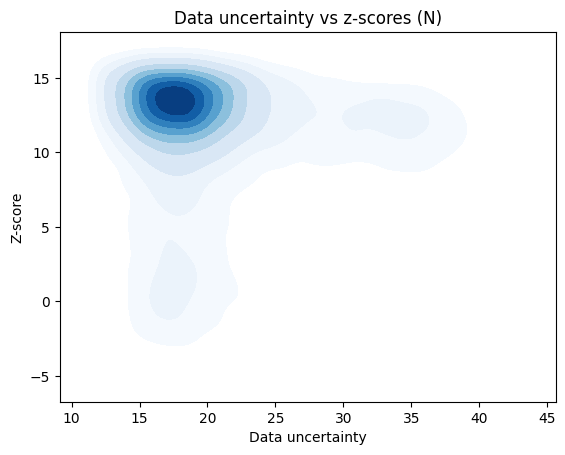

In [77]:
# plot model uncertainty vs z-scores
sns.kdeplot(x=data_uncertainty, y=val_df['zscores'], cmap="Blues", shade=True, shade_lowest=False);
plt.title("Data uncertainty vs z-scores (N)");
plt.xlabel("Data uncertainty");
plt.ylabel("Z-score");